In [30]:
import jax
# Enable Float64 for more stable matrix inversions.
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
import jax.random as jr
from jaxtyping import install_import_hook, Array, Float
from dataclasses import dataclass

with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax as gpx
    
from gpjax.kernels.transformations.invariant import FiniteGroup, SumGroupInvariantKernel, ProductGroupInvariantKernel

import matplotlib.pyplot as plt
from matplotlib import rcParams

key = jr.PRNGKey(12345)

In [116]:
# ground truth is a simple solenoidal field
def f(x): # [n, 2] -> [n, 2]
    return jnp.hstack([x[:,1:2], -x[:,0:1]])

# helper function to massage into form for 2d outputs in GPjax
def convert_to_3d_dataset(X, y): 
    # inputs go from [n, 2] -> [2*n, 3]
    # outputs go from [n, 2] -> [2*n, 1]
    inputs = jnp.hstack([X.repeat(2, axis=0), jnp.tile(jnp.array([[0.0, 1.0]]), len(X)).T])
    outputs = y.reshape(-1,1)
    return gpx.dataset.Dataset(inputs, outputs)

# helper function to make plots
def plot_fields_2d(X, y): # [2*n, 3], [2*n, 1]
    y_plot = y.reshape(-1,2)
    x_plot = X[:,0:2].reshape(-1,2)
    plt.figure()
    plt.quiver(x_plot[::2,0], x_plot[::2,1],y_plot[:,0], y_plot[:,1] , angles="xy")




# sample a dataset of 15 observations 
n = 4
X = jr.uniform(key, shape=(n,2), minval=-1.5, maxval=1.5)
D = convert_to_3d_dataset(X, f(X))

# also make a grid for evals
n_test = 100
X_test = jr.uniform(key, shape=(n_test,2), minval=-1.5, maxval=1.5)
D_test =convert_to_3d_dataset(X_test,f(X_test))


Optimization terminated successfully.
         Current function value: 5.477645
         Iterations: 39
         Function evaluations: 41
         Gradient evaluations: 41


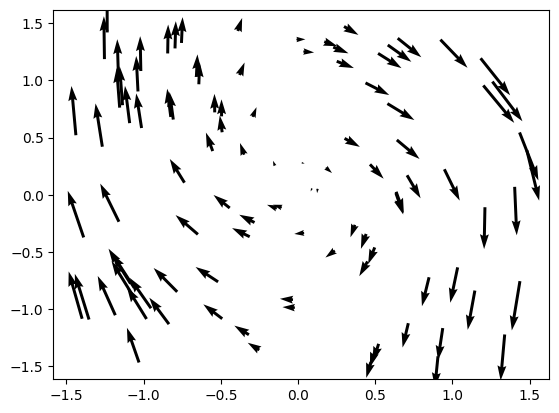

In [117]:
@dataclass
class VelocityKernel(gpx.kernels.AbstractKernel):
    kernel0: gpx.kernels.AbstractKernel = gpx.kernels.RBF(active_dims=[0, 1])
    kernel1: gpx.kernels.AbstractKernel = gpx.kernels.RBF(active_dims=[0, 1])

    def __call__(
        self, X: Float[Array, "1 D"], Xp: Float[Array, "1 D"]
    ) -> Float[Array, "1"]:
        # standard RBF-SE kernel is x and x' are on the same output, otherwise returns 0
        z = jnp.array(X[2], dtype=int)
        zp = jnp.array(Xp[2], dtype=int)
        # achieve the correct value via 'switches' that are either 1 or 0
        k0_switch = ((z + 1) % 2) * ((zp + 1) % 2)
        k1_switch = z * zp
        return k0_switch * self.kernel0(X, Xp) + k1_switch * self.kernel1(X, Xp)


# fit the velocity GP
prior = gpx.gps.Prior(mean_function=gpx.mean_functions.Zero(), kernel=VelocityKernel())
likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n)
posterior = prior * likelihood
opt_posterior, history = gpx.fit_scipy(
    model=posterior,
    objective=gpx.objectives.ConjugateMLL(negative=True),
    train_data=D,
)

# predict with model on test grid
velocity = opt_posterior.predict(D_test.X, D)
velocity_mean = velocity.mean()[:,None]

plot_fields_2d(D_test.X, velocity_mean[:, None])

Optimization terminated successfully.
         Current function value: 5.477645
         Iterations: 39
         Function evaluations: 41
         Gradient evaluations: 41


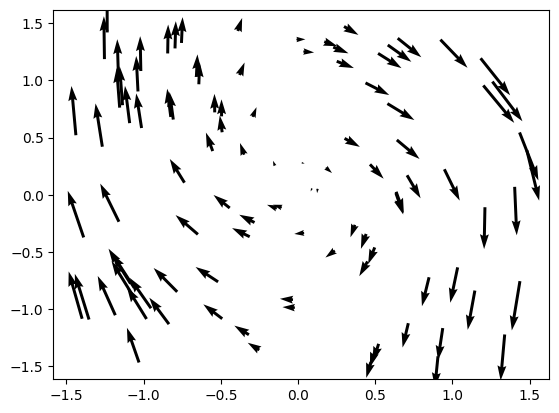

In [123]:
from gpjax.kernels import AbstractKernel
from gpjax.kernels.transformations.invariant import AbstractGroup



@dataclass
class RotationEquivariantVelocityKernel(AbstractKernel):
    r"""todo add fundamental domain"""
    kernel0: gpx.kernels.AbstractKernel = gpx.kernels.RBF(active_dims=[0, 1])
    kernel1: gpx.kernels.AbstractKernel = gpx.kernels.RBF(active_dims=[0, 1])

    


    def __call__(
        self,
        x: Float[Array, " D"],
        y: Float[Array, " D"],
    ) -> ScalarFloat:
        r"""Evaluate the kernel on a pair of inputs. todo

        Args:
            x (Float[Array, " D"]): The left hand input of the kernel function.
            y (Float[Array, " D"]): The right hand input of the kernel function.

        Returns
        -------
            ScalarFloat: The evaluated kernel function at the supplied inputs.
        """


        x_orbit, y_orbit = self.group.orbit(x), self.group.orbit(y) # [n_group_elements, D], [n_group_elements, D]

        k_xy_0 = self.kernel0.cross_covariance( # [n_group_elements * n_goup_elements]
            jnp.hstack([x_orbit, jnp.zeros((jnp.shape(x_orbit)[0], 1))]),
            jnp.hstack([y_orbit, jnp.zeros((jnp.shape(x_orbit)[0], 1))])
            ) 
        k_xy_1 = self.kernel1.cross_covariance( # [n_group_elements * n_goup_elements]
            jnp.hstack([x_orbit, jnp.ones((jnp.shape(x_orbit)[0], 1))]),
            jnp.hstack([y_orbit, jnp.ones((jnp.shape(x_orbit)[0], 1))])
            ) 

        k = self.group.orbit()
        
        




        return jnp.sum(k_xy)



# fit the equivariant GP
prior = gpx.gps.Prior(mean_function=gpx.mean_functions.Zero(), kernel=VelocityKernel())
likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n)
posterior = prior * likelihood
opt_posterior, history = gpx.fit_scipy(
    model=posterior,
    objective=gpx.objectives.ConjugateMLL(negative=True),
    train_data=D,
)

# predict with model on test grid
velocity = opt_posterior.predict(D_test.X, D)
velocity_mean = velocity.mean()[:,None]

plot_fields_2d(D_test.X, velocity_mean[:, None])

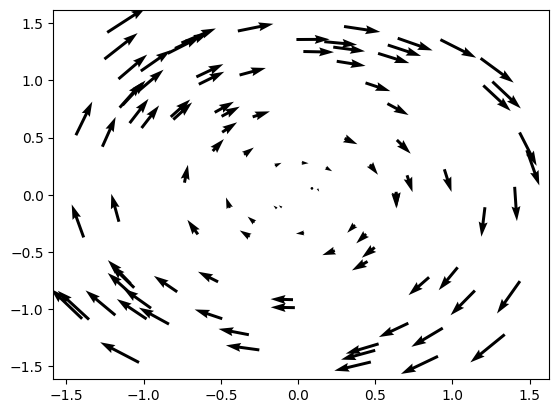

In [55]:






def label_position(data):
    # introduce alternating z label
    n_points = len(data[0])
    label = jnp.tile(jnp.array([0.0, 1.0]), n_points)
    return jnp.vstack((jnp.repeat(data, repeats=2, axis=1), label)).T

# change vectors y -> Y by reshaping the velocity measurements
def stack_velocity(data):
    return data.T.flatten().reshape(-1, 1)

def dataset_3d(pos, vel):
    return gpx.Dataset(label_position(pos), stack_velocity(vel))


    





In [57]:
D.y


Array([[-1.30704561],
       [ 1.30489821],
       [-1.49847951],
       [ 1.16281164],
       [ 0.88936404],
       [-1.35747529],
       [ 0.48976743],
       [ 0.75746749],
       [ 1.27008166],
       [ 0.39439742],
       [-1.16692958],
       [-0.36442732],
       [ 0.51031891],
       [ 0.6949047 ],
       [ 0.3058714 ],
       [-0.05126326],
       [ 0.77397166],
       [-1.44611544],
       [ 0.92567309],
       [-0.46245175],
       [-0.03981571],
       [-0.94817329],
       [-0.29935367],
       [-1.46352233],
       [-1.30750049],
       [ 1.07243255],
       [-1.20562837],
       [-0.81916385],
       [ 0.35292699],
       [-1.32584519]], dtype=float64)

In [58]:
y


Array([[-1.30704561, -0.05126326],
       [ 1.30489821,  0.77397166],
       [-1.49847951, -1.44611544],
       [ 1.16281164,  0.92567309],
       [ 0.88936404, -0.46245175],
       [-1.35747529, -0.03981571],
       [ 0.48976743, -0.94817329],
       [ 0.75746749, -0.29935367],
       [ 1.27008166, -1.46352233],
       [ 0.39439742, -1.30750049],
       [-1.16692958,  1.07243255],
       [-0.36442732, -1.20562837],
       [ 0.51031891, -0.81916385],
       [ 0.6949047 ,  0.35292699],
       [ 0.3058714 , -1.32584519]], dtype=float64)

In [52]:
D.X


Array([[ 0.05126326, -1.30704561,  0.        ],
       [ 0.05126326, -1.30704561,  1.        ],
       [-0.77397166,  1.30489821,  0.        ],
       [-0.77397166,  1.30489821,  1.        ],
       [ 1.44611544, -1.49847951,  0.        ],
       [ 1.44611544, -1.49847951,  1.        ],
       [-0.92567309,  1.16281164,  0.        ],
       [-0.92567309,  1.16281164,  1.        ],
       [ 0.46245175,  0.88936404,  0.        ],
       [ 0.46245175,  0.88936404,  1.        ],
       [ 0.03981571, -1.35747529,  0.        ],
       [ 0.03981571, -1.35747529,  1.        ],
       [ 0.94817329,  0.48976743,  0.        ],
       [ 0.94817329,  0.48976743,  1.        ],
       [ 0.29935367,  0.75746749,  0.        ],
       [ 0.29935367,  0.75746749,  1.        ],
       [ 1.46352233,  1.27008166,  0.        ],
       [ 1.46352233,  1.27008166,  1.        ],
       [ 1.30750049,  0.39439742,  0.        ],
       [ 1.30750049,  0.39439742,  1.        ],
       [-1.07243255, -1.16692958,  0.   

In [53]:
D.y


Array([[-1.30704561],
       [ 1.30489821],
       [-1.49847951],
       [ 1.16281164],
       [ 0.88936404],
       [-1.35747529],
       [ 0.48976743],
       [ 0.75746749],
       [ 1.27008166],
       [ 0.39439742],
       [-1.16692958],
       [-0.36442732],
       [ 0.51031891],
       [ 0.6949047 ],
       [ 0.3058714 ],
       [-0.05126326],
       [ 0.77397166],
       [-1.44611544],
       [ 0.92567309],
       [-0.46245175],
       [-0.03981571],
       [-0.94817329],
       [-0.29935367],
       [-1.46352233],
       [-1.30750049],
       [ 1.07243255],
       [-1.20562837],
       [-0.81916385],
       [ 0.35292699],
       [-1.32584519]], dtype=float64)

Optimization terminated successfully.
         Current function value: 40.409637
         Iterations: 28
         Function evaluations: 33
         Gradient evaluations: 33


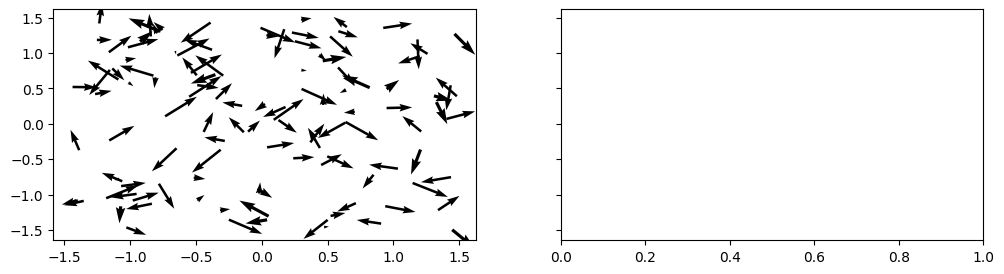

In [34]:
D_test.X.shape



(30, 3)

In [13]:
X.shape



(15, 2)

In [3]:
# prepare some plotting utilities
x1_plot, x2_plot = jnp.meshgrid(jnp.linspace(-1.5,1.5,50), jnp.linspace(-1.5,1.5,50))
xplot2d = jnp.stack([x1_plot.reshape(-1), x2_plot.reshape(-1)]).T # [2500, 2]
xplot1d = jnp.stack([jnp.linspace(-1.5,1.5,50), jnp.linspace(-1.5,1.5,50)]).T # [50, 2]
def contour_plot(Z, ax):
    ax.contourf(x1_plot, x2_plot, Z.reshape(50, 50))
    ax.scatter(X[:,0], X[:,1],c="red", marker="x", label="data")
    ax.set_xlim(-1.5,1.5)
    ax.set_ylim(-1.5,1.5)


In [ ]:
def label_position(data):
    # introduce alternating z label
    n_points = len(data[0])
    label = jnp.tile(jnp.array([0.0, 1.0]), n_points)
    return jnp.vstack((jnp.repeat(data, repeats=2, axis=1), label)).T


# change vectors y -> Y by reshaping the velocity measurements
def stack_velocity(data):
    return data.T.flatten().reshape(-1, 1)


def dataset_3d(pos, vel):
    return gpx.Dataset(label_position(pos), stack_velocity(vel))



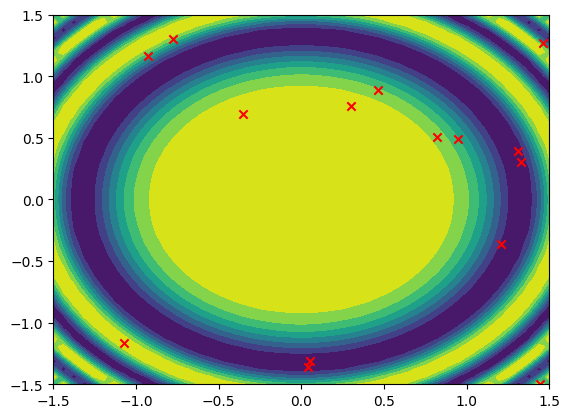

In [51]:
def build_prior_and_plot_samples(kernel: gpx.kernels.AbstractKernel):
    meanf = gpx.mean_functions.Zero()
    prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)
    samples = prior.predict(xplot2d).sample(seed=jr.PRNGKey(12345), sample_shape=(5,))
    _, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,4))
    for i in range(5):
        contour_plot(samples[i,:], ax[i])
    return prior



def fit_and_plot_samples(kernel: gpx.kernels.AbstractKernel):
    meanf = gpx.mean_functions.Zero()
    likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n, obs_stddev=1e-3)
    obj = gpx.objectives.ConjugateMLL(negative=True)
    prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)
    posterior = prior * likelihood
    opt_posterior, _ = gpx.fit_scipy(model=posterior, objective=obj, train_data=D, verbose=True)
    samples = opt_posterior.predict(xplot2d, D).sample(seed=jr.PRNGKey(12345), sample_shape=(5,))
    _, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,4))
    for i in range(5):
        contour_plot(samples[i,:], ax[i])
    return opt_posterior

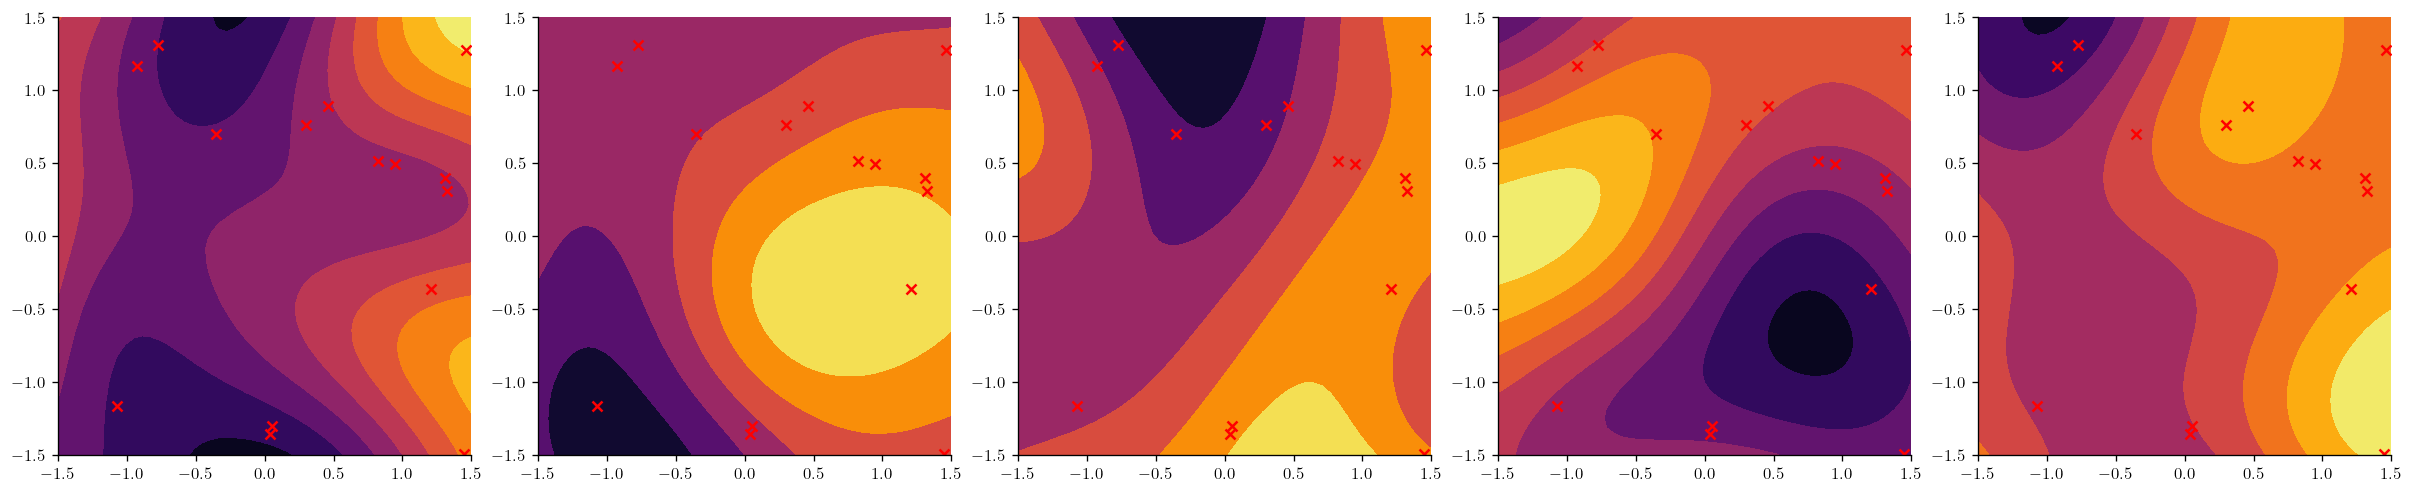

In [29]:
kernel = gpx.kernels.RBF(lengthscale=jnp.array([1.0, 1.0]), variance = jnp.var(D.y))
prior = build_prior_and_plot_samples(kernel)

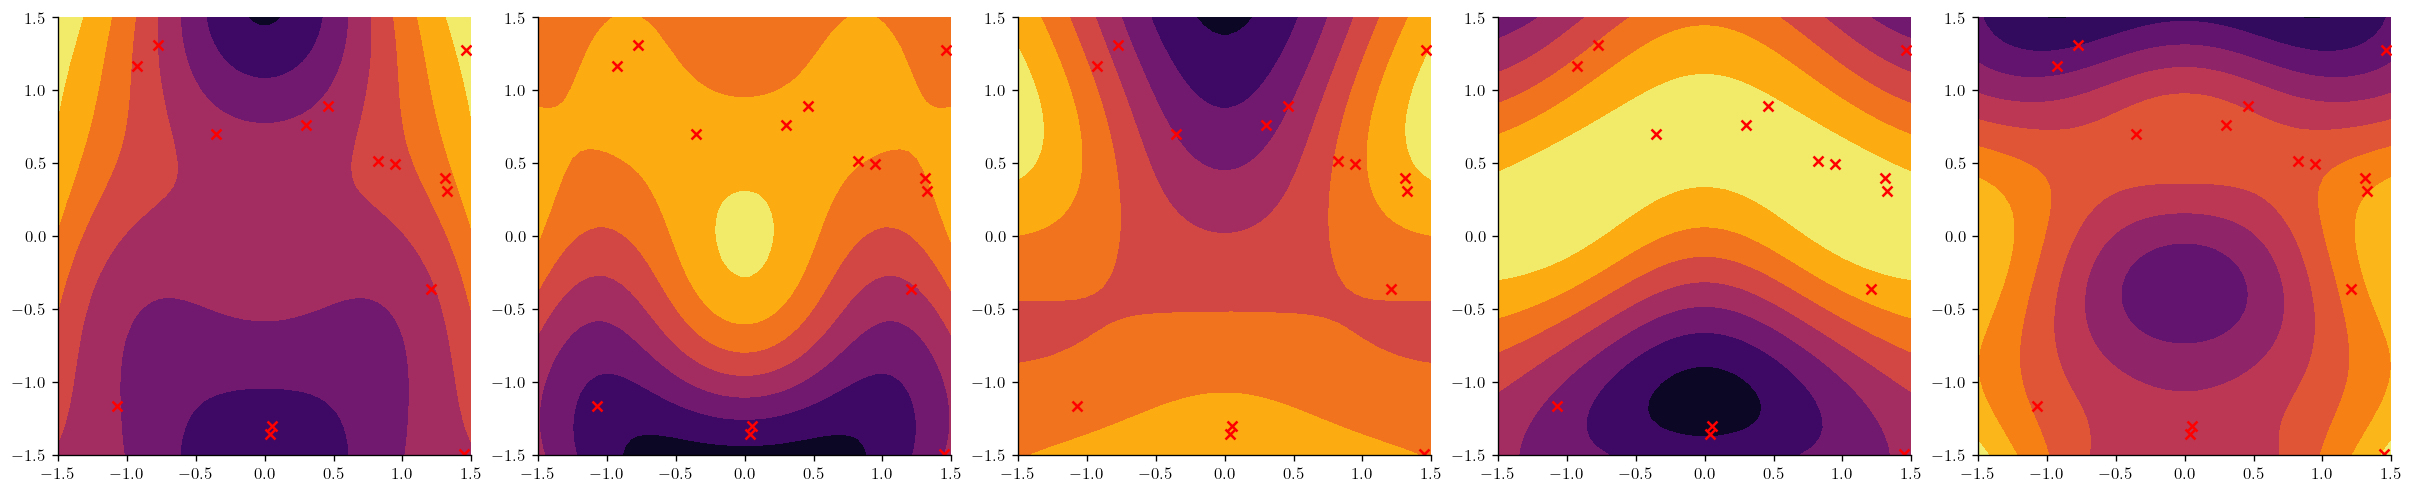

In [30]:
group_action = lambda x: jnp.stack([x, x * jnp.array([-1,1])], axis=0)
kernel = SumGroupInvariantKernel(base_kernel = kernel, group = FiniteGroup(group_action))
prior = build_prior_and_plot_samples(kernel)

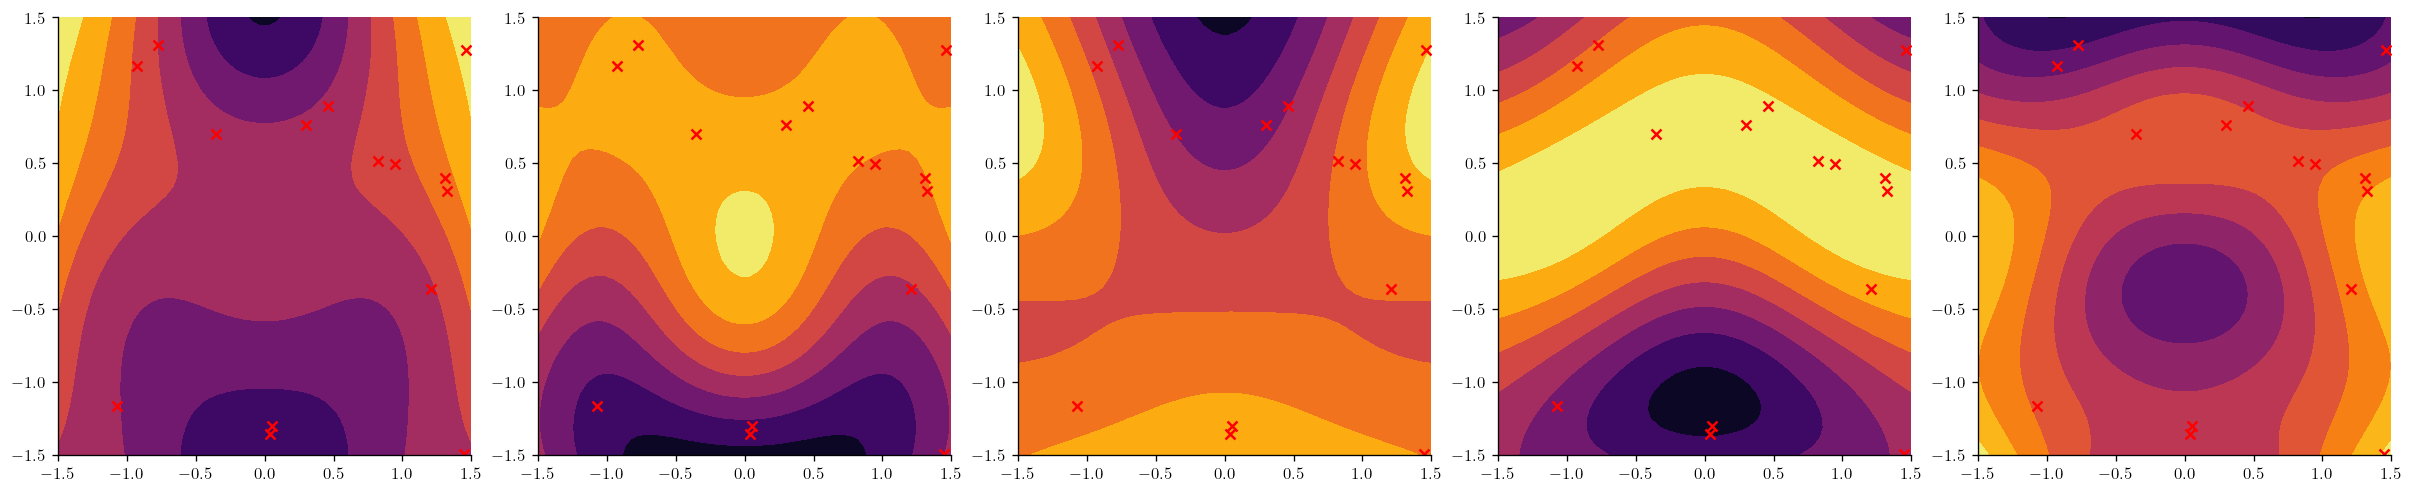

In [44]:
group_action = lambda x: jnp.stack([jnp.abs(x[0]),x[1]], axis=0).reshape(1,-1)
kernel = SumGroupInvariantKernel(base_kernel = kernel, group = FiniteGroup(group_action))
prior = build_prior_and_plot_samples(kernel)

Optimization terminated successfully.
         Current function value: 19.328203
         Iterations: 39
         Function evaluations: 42
         Gradient evaluations: 42


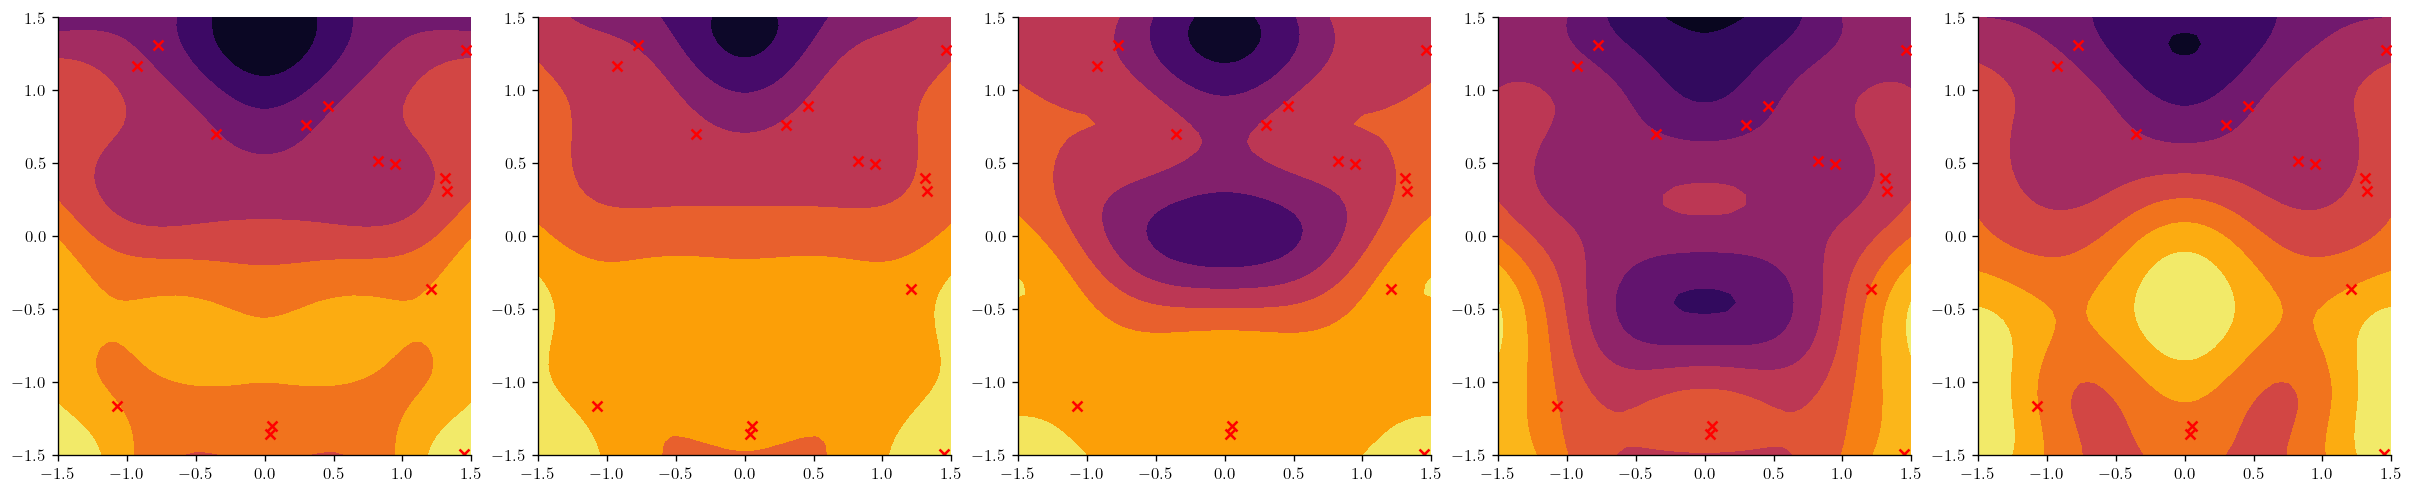

In [52]:
opt_posterior = fit_and_plot_samples(kernel)